# La régression logistique ☕️

**<span style='color:blue'> Objectifs de la séquence</span>** 
* Concevoir&nbsp;:
    * la régression logistique d'un point de vue prédictif,
    * la régression logistique au travers d'un problème d'optimisation.
* Être capable&nbsp;:
    * d'implémenter un algorithme de descente de gradient,
    * de transformer les variables d'entrée pour rendre le modèle non linéaire,
    * d'utiliser la librairie $\texttt{sklearn}$.
* De s'initier à la notion de régularisation et de sélection de variables.



 ----

## I. Introduction

Dans cette partie, nous allons implémenter un algorithme de classification supervisée. Contrairement à la régression linéaire qui consiste à prédire une valeur scalaire, la régression logistique a pour but d'estimer la probabilité d'une variable catégorielle. Une variable catégorielle correspond à un nombre entier compris entre $1$ et $K$ pour un problème à $K$ classes où la notion de proximité (1 est plus proche de 2 que de 3) est oubliée. Nous considererons dans un premier temps un cas simple à deux classes. Puis nous mettrons en place un classificateur de chiffre manuscrit compris entre 0 et 9.

**La régression logistique** cherche à estimer la probabilité $\mathbb{P}(Y=1|X=\boldsymbol{x})$ où $y\in\{0,1\}$. On obtient la probabilité inverse de la manière suivante : $\mathbb{P}(Y=0|X=\boldsymbol{x})$=1-$\mathbb{P}(Y=1|X=\boldsymbol{x})$. De la même manière que pour la séquence traitant de la régression linéaire et par un abus de langage fort, nous utiliserons de manière interchangeable la notation $\boldsymbol{x}, y$ pour faire référence aux variables aléatoires et à leur réalisation. Dans le cas de la régression logistique, on suppose que le paramètre naturel $\eta$ de notre loi est estimable à partir d'une combinaison linéaire des variables explicatives :

$$\exists\boldsymbol{\beta}\in\mathbb{R}^d,\ \eta(\boldsymbol{x}) = \langle\boldsymbol{\beta}, \boldsymbol{x}\rangle$$

Attention, la notation $\eta$ est aussi utilisée en machine learning afin de faire directement référence à :

$$\eta(x)=\mathbb{P}(Y=1|X=\boldsymbol{x}).$$

La fonction de lien $\sigma$ est la fonction qui permet du passer du paramètre naturel à notre probabilité. Dans le cas d'une loi de Bernoulli (loi d'une variable binaire), la fonction de lien est la sigmoid :

$$\begin{aligned}
\sigma:\mathbb{R}&\rightarrow \big[0, 1\big]\\
z&\mapsto (1+\text{exp}(-z))^{-1}
\end{aligned}$$


La fonction sigmoid est illustrée par la figure suivante.

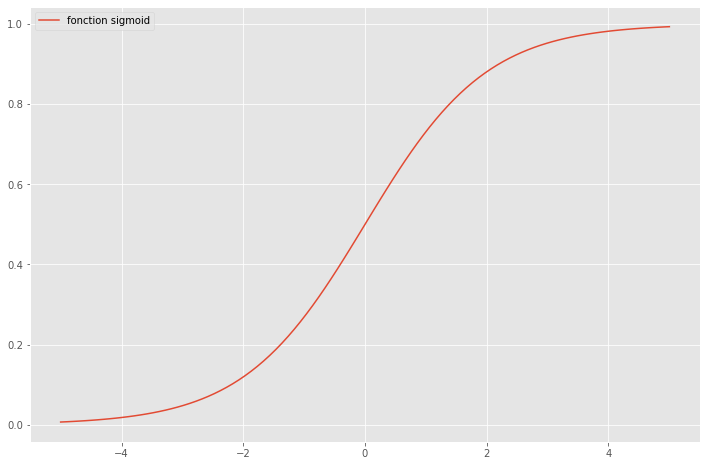

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import expit as sigmoid

# configuration generale de matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12.0, 8.0)
plt.style.use('ggplot')

x = np.linspace(-5, 5, 100)
y = sigmoid(x)  # (1+np.exp(-x))**(-1) + numerical stability.. Question ?
plt.plot(x, y, label="fonction sigmoid")
plt.legend()
plt.show()

Si le paramètre naturel $\eta$ est négatif, la probabilité estimée sera inférieure à $0.5$ et notre échantillon appartiendra plus probablement à la classse $0$ ($y=0$). À l'inverse, si $\eta$ est positif, on dira que notre échantillon appartient à la classe positive.

il est ainsi possible d'obtenir notre probabilité de la manière suivante :


$$\mathbb{P}(y_{\text{new}}=1|\boldsymbol{x_{\text{new}}}, \boldsymbol{\beta})=\sigma(\boldsymbol{\beta}^T\boldsymbol{x_{\text{new}}} ).$$

De la même manière que pour la régression linéaire, on supposera que le vecteur $\boldsymbol{x}$ possède une dimension $0$ avec la valeur $1$ faisant office de biais.

---
**Un problème de classification avec une séparation par hyperplan.**

On dit que deux vecteurs $u$ et $v$ sont orthogonaux si leur produit scalaire est nul :

$$\langle u, v \rangle = 0$$


La frontière de décision est l'ensemble de tous les points qu'il n'est pas possible de classer $1$ ou $0$. C'est l'ensemble des points tels que $\mathbb{P}(y=1|\boldsymbol{x}, \boldsymbol{\beta})=0.5$. Dit encore autrement, et en nous référant à la figure ci-dessus, il s'agit de l'ensemble des points tels que le paramètre naturel estimé $\eta(\boldsymbol{x})=\boldsymbol{\beta}^T\boldsymbol{x}=0$. Dit encore autrement, il s'agit de l'ensemble des points orthogonaux au vecteur de paramètres $\boldsymbol{\beta}$. Le vecteur $\boldsymbol{\beta}$ est appelé vecteur normal à l'hyperplan séparateur.  

---

La régression logistique nous donne la probabilité $\mathbb{P}(y_{\text{new}}=1|\boldsymbol{x_{\text{new}}}, \boldsymbol{\beta})$. Il est trivial d'obtenir la classe à partir de ce score. On dira que l'échantillon appartient à la classe $1$ si la probabilité est supérieure à $0.5$ et à la classe $0$ dans le cas contraire.

On peut parfois vouloir bouger ce seuil. Ainsi, si on prédit qu'un patient a $45\%$ de chance d'avoir un cancer, on voudra refaire des tests plutôt que lui dire que tout est bon.

## II. Construction d'un jeu de données

Considérons le modèle génératif suivant :


$$\boldsymbol{\beta} \sim \mathcal{N}(0, 1)^3 \in \mathbb{R}^3$$

Nos échantillons sont simulés via une loi normale de moyenne centrée sur la frontière de décision. Notons $\boldsymbol{\beta^\prime}=\begin{bmatrix}\beta_1\\ \beta_2\end{bmatrix}$. On fixera cette moyenne de la manière suivante :

$$\boldsymbol{\mu}=\boldsymbol{\beta^\prime}\Bigg(-\frac{\beta_0}{\lVert \boldsymbol{\beta^\prime}\rVert^2}
\Bigg).$$


**<span style='color:blue'> Exercice</span>** 
**Vérifier qu'on obtient bien :**

$$\langle \boldsymbol{\beta^\prime}, \boldsymbol{\mu}\rangle + \beta_0=0$$

**Dit autrement, il s'agit de vérifier que $\boldsymbol{\mu}$ est bien sur la frontière.**



 ----

La moyenne de notre loi normale étant maintenant fixée, nous pouvons simuler nos données :

$$\boldsymbol{x}\sim\mathcal{N}(\boldsymbol{\mu}, \boldsymbol{1})\in\mathbb{R}^2$$


La classe d'un échantillon est donnée par :

$$\begin{aligned}
y_i=\begin{cases}
1\text{ si }\langle\boldsymbol{\beta^\prime},\boldsymbol{x_i}\rangle +\beta_0>0\\
0\text{ sinon.}
\end{cases}\end{aligned}$$

Notre problème est donc par construction totalement linéairement séparable dans le sens où la frontière de décision définie par le vecteur normal $\boldsymbol{\beta^\prime}$ et par le biais $\beta_0$ sépare totalement et sans erreur notre jeu de données.

Le code ci dessous affiche le jeux de données ainsi que la représentation graphique de la frontière de decision $f(x)=-\frac{\beta_1}{\beta_2}x_1-\frac{\beta_0}{\beta_2}$. On vérifie facilement que le vecteur construit tel que $\beta_2=f(x)$ pour $\beta_1$ et $\beta_0$ quelconques (à part les cas particuliers) sont bien sur la frontière.

In [2]:
import numpy as np

real_beta = np.random.normal(0, 1, size=3)

def sample_data(n, beta):
    # constructing mean 
    mu = beta[1:3]*(-beta[0]/(np.linalg.norm(beta[1:3])**2))
    # covariance is the same for each class
    cov  = np.diag(np.ones(2))
    
    # sampling x and adding the bias
    X = np.insert(np.random.multivariate_normal(mu, cov, size=n), 0, 1, axis=1)
    
    # the label is deterministic
    y = (np.dot(X, beta)>0)*1
    
    return X, y
    
X, y = sample_data(100, real_beta)

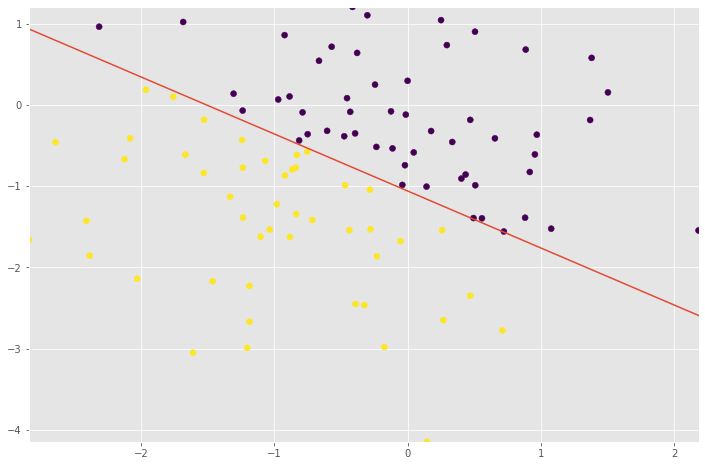

In [3]:
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

matplotlib.rcParams['figure.figsize'] = (12.0, 8.0)
plt.style.use('ggplot')

def plot(X, y, beta=None, predictor=None, title=None):
    ymin_ = X[:,2].min()
    ymax_ = X[:,2].max()
    min_ = X[:,1].min()
    max_ = X[:,1].max()
    
    if predictor is not None:
        h = 0.02
        xx, yy = np.meshgrid(np.arange(min_, max_, h), np.arange(ymin_, ymax_, h))
        Z = predictor.predict(np.insert(np.c_[xx.ravel(), yy.ravel()], 0, 1, axis=1))
        Z = Z.reshape(xx.shape)
        plt.pcolormesh(xx, yy, Z,shading='auto', alpha=0.01)
    
    plt.scatter(X[:,1], X[:,2], c=y)
    
    if beta is not None:
        x_ = np.linspace(min_, max_, 500)
        y_  = -beta[0]/beta[2] - x_ * beta[1] / beta[2]
        plt.plot(x_, y_)
    
    if title is not None:
        plt.title(title)
    plt.xlim(min_, max_)
    plt.ylim(ymin_, ymax_)
    plt.show()
plot(X, y, real_beta)

## III. Fonction objectif et gradient

De la même manière que pour la régression linéaire, nous pouvons obtenir notre fonction objectif à partir de la formulation de la vraisemblance de notre problème :

$$\mathcal{L}_{\boldsymbol{\beta}}(\mathcal{S})=\prod_{(\boldsymbol{x}, y)\in\mathcal{S}}\mathbb{P}(y=1|\boldsymbol{x},\boldsymbol{\beta})^y\mathbb{P}(y=0|\boldsymbol{x},\boldsymbol{\beta})^{1-y}$$


Le paramètre maximisant la vraisemblance est aussi celui minimisant la log vraisemblance négative :

$$J(\beta)=-\text{log}\big(\mathcal{L}_{\boldsymbol{\beta}}(\mathcal{S})\big)=-\sum_{(\boldsymbol{x}, y)\in\mathcal{S}}y\text{log}(p)+(1-y)\text{log}(1-p)$$


où $p=\mathbb{P}(y=1|\boldsymbol{x},\boldsymbol{\beta})=\sigma(\boldsymbol{\beta}^T\boldsymbol{x})$. Cette fonction objectif, ou *loss* s'appelle la *cross entropy* ou entropie croisée. On obtient donc :

$$\hat{\boldsymbol{\beta}}=\text{argmin}_{\boldsymbol{\beta}}\Big[-\sum_{(\boldsymbol{x}, y)\in\mathcal{S}}y\text{log}(\sigma(\boldsymbol{\beta}^T\boldsymbol{x}))+(1-y)\text{log}(1-\sigma(\boldsymbol{\beta}^T\boldsymbol{x}))\Big]$$

La fonction $J$ est ainsi ce qu'on souhaite minimiser.

**<span style='color:blue'> Question 1</span>** 
**Compléter la méthode $\texttt{val}$ de l'objet $\texttt{CrossEntropy}$ ci-dessous.**



 ----

**<span style='color:blue'> Question 2</span>** 
**Calculez les dérivées partielles $\partial J(\beta)/\partial \beta_0$, $\partial J(\beta)/\partial \beta_1$ et  $\partial J(\beta)/\partial \beta_2$ de la fonction de coût de notre modèle de régréssion logistique. Complétez la méthode $\texttt{grad}$ de l'objet $\texttt{CrossEntropy}$ ci dessous.**



 ----
**<span style='color:green'> Indice</span>** 
Rappellez-vous que la dérivée d'une composition de fonction s'écrit $(g \circ f)^\prime (x) = f^\prime(x) g^\prime(f(x))$ et que la fonction de coût de notre modèle s'écrit:


$$J(\boldsymbol{\beta}) = \frac{1}{n}\sum_j^n g_1(f_{\boldsymbol{\beta}}(x_j)) + g_2(f_{\boldsymbol{\beta}}(x_j))$$

avec $g$, $f$, etc. choisis intelligemment.



 ----

**<span style='color:blue'> Question 2${}^\star$</span>** 
**Calculez le gradient de la fonction $J(\boldsymbol{\beta})$ en utilisant les dérivées matricielles et modifiez la méthode $\texttt{grad}$ ci-dessous en conséquence.**



 ----


**<span style='color:blue'> Question 3</span>** 
**Complétez la méthode $\texttt{predict}$ de l'objet ci-dessous**



 ----

In [ ]:
class CrossEntropy(object):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.idx = np.array([i for i in range(self.X.shape[0])])
        self._pos = 0
        
    def _format_ndarray(arr):
        arr = np.array(arr) if type(arr) is not np.ndarray else arr
        return arr.reshape((arr.shape[0], 1)) if len(arr.shape) == 1 else arr
    
    def predict(self, X):
    
        ####### Complete this part ######## or die ####################
        ...
        ###############################################################

        return y_pred
    
    def _sigmoid(X, beta):
        return (1+np.exp(-np.dot(X, beta)))**(-1)
    
    def val(self, beta):
        beta = CrossEntropy._format_ndarray(beta)

        ####### Complete this part ######## or die ####################
        ...
        ...
        return ...
        ###############################################################
    
    def _shuffle(self):
        np.random.shuffle(self.idx)
    
    def grad(self, beta, batch_size=-1):
        batch_size = self.X.shape[0] if batch_size == -1 else batch_size
        idx = self.idx[self._pos:self._pos+batch_size]

        self._pos = (self._pos+batch_size) % self.X.shape[0]
        if self._pos == 0:
            self._shuffle()
            
        X, y = self.X[idx], self.y[idx]
        y = CrossEntropy._format_ndarray(y)

        
        beta = CrossEntropy._format_ndarray(beta)
        
        ####### Complete this part ######## or die ####################
        ...
        return ...
        ###############################################################
    

l = CrossEntropy(X, y)
print('La valeur de la loss pour beta est', l.val(real_beta))

print('Le gradient pour beta est\n', l.grad(real_beta))


## IV. Optimisation et dynamique de la descente de gradient dans le cas séparable

Récupérons l'algorithme de descente de gradient développé lors du TP sur la régression linéaire. Il s'agit exactement du même code à la différence près qu'on optimise la fonction $\texttt{CrossEntropy}$ et non $\texttt{LeastSquare}$.

In [ ]:
class GradientDescent(object):
    init = np.random.uniform(-4, 4, size=3).reshape((3, 1))
    def __init__(self, X, y, loss=CrossEntropy):
        self.loss = loss(X, y)
        
    def optimize(self, learning_rate = 0.5, nb_iterations=10, beta=init, batch_size=-1):
        param_trace = [beta.T[0]]
        loss_trace = [self.loss.val(beta)]
        for i in range(nb_iterations):
            beta = beta - learning_rate * self.loss.grad(beta, batch_size=batch_size)
            param_trace.append(beta.T[0])
            loss_trace.append(self.loss.val(beta))
            
        return param_trace, loss_trace


gd = GradientDescent(X, y)


La dimension de l'espace des paramètres est $3$ et il n'est plus possible de visualiser ce dernier pour voir si notre algorithme d'optimisation fonctionne. 

**<span style='color:blue'> Exercice</span>** 
**Proposez une stratégie permettant d'évaluer la convergence de notre algorithme. Jouez sur le *learning rate* et sur le nombre d'itérations afin d'améliorer la qualité de notre estimateur.**



 ----

In [ ]:
####### Complete this part ######## or die ####################
...
...
###############################################################


---

Analysons maintenant l'évolution de notre paramètres en terme de distance par rapport au "vrai" paramètre ainsi que l'évolution de la *loss* pour plusieurs configurations d'apprentissage.

In [ ]:
distance = []
loss_evolution = []
for it in range(10, 1000, 10):
    params, loss_trace = gd.optimize(nb_iterations=it, learning_rate=1.)
    distance.append(np.linalg.norm(params[-1]-real_beta))
    loss_evolution.append(loss_trace[-1])
plt.figure()
plt.plot(list(range(10, 1000, 10)),distance)
plt.title("Distance Euclidienne entre les parametres estimes et la vraie solution en fonction du"+
          " nombre d'itérations")
plt.show()
plt.figure()
plt.title("Évolution de la loss en fonction du nombre d'itérations")
plt.plot(list(range(10, 1000, 10)), loss_evolution)
plt.show()


On remarque que notre vecteur de paramètres se rapproche dans un premier temps de la vraie solution (voire même pas) puis s'en écarte inéxorablement. Il est légitime de se poser la question du bug dans l'algorithme. Cependant, l'affichage de la *loss* nous montre que plus on s'écarte du vrai paramètre, plus notre modèle *fit* correctement les données dans le sens où il minimise bien la fonction objectif. De plus un affichage de la frontière de décision ainsi calculée montre que notre frontière de décision semble visuellement assez proche de la vraie solution.

In [ ]:
plot(X, y, params[-1], title='Solution estimee')
plot(X, y, real_beta, title='Vraie solution')


Il se produit donc un phénomène qu'il convient de comprendre. Ce phénomène est en réalité le pendant du régime interpolatoire (i.e. 0 erreur) de la régression linéaire pour la régression logistique.

Étudions cela plus en détails.

**<span style='color:blue'> Exercice 1</span>** 
**Montrer que si $\beta$ est le vecteur normal d'un hyperplan qui sépare correctement (i.e. aucune erreur) les deux classes de notre jeu de données, alors $k\beta,\ k\in\mathbb{R}^{\star+}$ est aussi un vecteur normal séparateur pour notre jeu de données.**



 ----
**<span style='color:blue'> Exercice 2</span>** 
**Montrer que si $\beta$ est le vecteur normal d'un hyperplan qui sépare correctement (i.e. aucune erreur) les deux classes de notre jeu de données, alors $J(\beta)>J(k\beta)$ si $k>1$.**



 ----

Autrement dit, s'il existe un vecteur $\beta$ qui définit une bonne frontière de décision avec aucune erreur, alors tout vecteur $\gamma=k\beta,\ k>0$ définira le même hyperplan. De plus, plus $k$ sera grand, plus notre loss sera petite. Cela nous indique qu'en réalité, la fonction $J(\beta)$ n'admet **aucun** minimum ou, d'un point de vue statistique, que le maximum de vraisemblance n'existe pas. On se rapproche du minimum de la fonction $J$ lorsque $\beta$ diverge vers l'infini.

D'un point de vue purement prédictif/classification, cela n'est pas gênant car toutes ces solutions définissent le même hyperplan qui n'est décrit que par la direction du vecteur $\beta$. D'un point de vue statistique, cela est plus gênant car les "probabilités" retournées par notre modèle convergent toutes soit vers $1$ soit vers $0$ et ne sont plus interprétables.

La figure suivante montre que bien que notre vecteur de paramètres diverge, son cosinus avec le vrai vecteur de paramètres tend vers $1$ : ils sont donc bien colinéaires.

In [ ]:
cos = []
for it in range(10, 1000, 10):
    params, loss_trace = gd.optimize(nb_iterations=it, learning_rate=1.)
    cos.append(np.dot(params[-1], real_beta)/(np.linalg.norm(params[-1])*np.linalg.norm(real_beta)))
plt.figure()
plt.title("Cosinus entre les parametres estimes et la vraie solution")
plt.plot(list(range(10, 1000, 10)), cos)
plt.show()


Ce n'est bien sûr pas exactement $1$ puisque notre vecteur est estimé sur un jeu de données empirique de taille finie.

## V. Optimisation et dynamique de la descente de gradient dans le cas non-séparable

À l'inverse, si le problème n'était pas séparable, une solution optimale existerait et notre algorithme s'en serait approché. Cette solution serait notre maximum de vraisemblance statistique.

**<span style='color:blue'> Exercice</span>** 
**Soit $\beta^\star$ le minimum de notre fonction $J$ tel qu'il existe un unique échantillon $(\boldsymbol{x}, y)$ mal classé. Montrer que $J(k\beta^\star)$ diverge lorsque $k$ tend vers l'infini.**



 ----

### Construction d'un jeu de données non-séparable

Considérons tout d'abord le modèle génératif suivant:


$$\boldsymbol{x^+} \sim \mathcal{N}(\mu^+, 1)^2 \in \mathbb{R}^2, \boldsymbol{x^-} \sim \mathcal{N}(\mu^-, 1)^2 \in \mathbb{R}^2$$

Les échantillons $\boldsymbol{x^+}$ sont associés à $y=1$ et $\boldsymbol{x^-}$ à $y=0$. La variable $y$ est notre variable binaire à expliquer. Le centre de chaque *cluster* est défini de la manière suivante :

$$\boldsymbol{\mu^{+/-}}=\boldsymbol{\beta^\prime}\Bigg(-\frac{\beta_0}{\lVert \boldsymbol{\beta^\prime}\rVert^2}\pm\rho
\Bigg),$$


où $\rho$ nous permet de contrôler l'écart du centre de chaque cluster avec la frontière de décision. De la même manière que précédemment, nous choissons une règle arbitraire pour générer aléatoirement les paramètres du "vrai" modèle en incluant un biais:


$$\boldsymbol{\beta} \sim \mathcal{N}(0, 1)^3 \in \mathbb{R}^3$$


Ainsi $\beta_1$ et $\beta_2$ correspondent aux paramètres associés à nos variables explicatives et $\beta_0$ est le biais.

In [ ]:
real_beta = np.random.normal(0, 1, size=3)

def sample_data(n, beta, rho=1):
    # constructing mean of each class
    mu_1 = beta[1:3]*((-beta[0]/(np.linalg.norm(beta[1:3])**2))-rho)
    mu_0 = beta[1:3]*((-beta[0]/(np.linalg.norm(beta[1:3])**2))+rho)
    # covariance is the same for each class
    cov  = np.diag(np.ones(2))
    
    # the two classes have the same number of samples
    X = np.concatenate([
        np.random.multivariate_normal(mu_1, cov, size=int(n/2)),
        np.random.multivariate_normal(mu_0, cov, size=int(n/2))
    ], axis=0)
    
    # the label is deterministic
    y = np.array([0 if i < int(n/2) else 1 for i in range(2*int(n/2))])
    
    # we shuffle the samples
    idx = [i for i in range(X.shape[0])]
    np.random.shuffle(idx)
    
    # we insert a bias
    return np.insert(X[idx], 0, 1, axis=1), y[idx]
    
X, y = sample_data(1000, real_beta, rho=2)

In [ ]:
plot(X, y, real_beta)

on retrace les mêmes courbes que nous avions réalisées précédemment et on constate la différence.

In [ ]:
gd = GradientDescent(X, y)

distance = []
loss_evolution = []
cos = []
for it in range(10, 1000, 10):
    params, loss_trace = gd.optimize(nb_iterations=it, learning_rate=1.)
    distance.append(np.linalg.norm(params[-1]-real_beta))
    loss_evolution.append(loss_trace[-1])
    cos.append(np.dot(params[-1], real_beta)/(np.linalg.norm(params[-1])*np.linalg.norm(real_beta)))
plt.figure()
plt.plot(list(range(10, 1000, 10)),distance)
plt.title("Distance Euclidienne entre les parametres estimes et la vraie solution en fonction du"+
          " nombre d'itérations")
plt.show()
plt.figure()
plt.title("Évolution de la loss en fonction du nombre d'itérations")
plt.plot(list(range(10, 1000, 10)), loss_evolution)
plt.show()

plt.figure()
plt.title("Cosinus entre les parametres estimes et la vraie solution")
plt.plot(list(range(10, 1000, 10)), cos)
plt.show()


On remarque qu'on ne converge pas vers le vecteur que nous avions utilisé lors de la construction du jeu de données. Cela est du au fait que nous ne nous sommes servi de ce vecteur que pour positionner l'hyperplan. Ainsi, nous avons utilisé sa direction et non sa norme. Rajoutons que maintenant le problème n'est plus séparable et notre vecteur estimé converge vers une valeur. On peut également confirmer que le problème n'est plus séparable car notre *loss* ne tend plus vers 0.

**<span style='color:blue'> Question</span>** 
**Quel processus génératif aurait pu être utilisé afin que le vecteur $\beta$ réel soit bien celui vers lequel on retombe lorsqu'on optimise notre problème ?**



 ----

**<span style='color:blue'> Exercice</span>** 
**Testez votre modèle génératif et comparez les résultats.**



 ----

In [ ]:
real_beta = np.random.normal(0, 0.1, size=3)
real_beta[1:3] *= 10

def perfect_data_sampler(n, beta):
    ####### Complete this part ######## or die ####################
    ...
    ...
    ...
    ...
    ...
    ...
    ...
    ###############################################################
    return X, y
    
X, y = perfect_data_sampler(1000, real_beta)


In [ ]:
plot(X, y, real_beta)


In [ ]:
gd = GradientDescent(X, y)

distance = []
loss_evolution = []
cos = []
for it in range(10, 1000, 10):
    params, loss_trace = gd.optimize(nb_iterations=it, learning_rate=1.)
    distance.append(np.linalg.norm(params[-1]-real_beta))
    loss_evolution.append(loss_trace[-1])
    cos.append(np.dot(params[-1], real_beta)/(np.linalg.norm(params[-1])*np.linalg.norm(real_beta)))
plt.figure()
plt.plot(list(range(10, 1000, 10)),distance)
plt.title("Distance Euclidienne entre les parametres estimes et la vraie solution en fonction du"+
          " nombre d'itérations")
plt.show()
plt.figure()
plt.title("Évolution de la loss en fonction du nombre d'itérations")
plt.plot(list(range(10, 1000, 10)), loss_evolution)
plt.show()

plt.figure()
plt.title("Cosinus entre les parametres estimes et la vraie solution")
plt.plot(list(range(10, 1000, 10)), cos)
plt.show()


Succès !

## VI. Transformation des variables explicatives

Considérons maintenant un jeu de données tel qu'il n'est pas possible de séparer nos deux classes linéairement.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def sample_data(n, sigma1=0.1, sigma2=0.3, r=2):
    class_1 = np.random.uniform(0, 2*np.pi, size=(int(n/2), 1))
    class_1 = np.concatenate(
        [r*np.cos(class_1), r*np.sin(class_1)], axis=1) + np.random.normal(0, 
                                                                       sigma1, 
                                                                       size=(int(n/2), 2))
    class_2 = np.random.normal(0, sigma2, size=(int(n/2), 2))
    X = np.insert(np.concatenate([class_1, class_2]), 0, 1, axis=1)
    y = np.array([1 if i < int(n/2) else 0 for i in range(2*int(n/2))])
    
    return X, y
    
X, y = sample_data(100)
plot(X, y)

On remarque assez naïvement et rapidement qu'une simple régression logistique n'est plus une solution acceptable.

In [ ]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(fit_intercept=False)
model.fit(X, y)
plot(X, y, beta=model.coef_[0])

**<span style='color:blue'> Exercice</span>** 
**Proposez une transformation polynomiale de vos variables explicatives permettant de résoudre correctement ce problème.**



 ----

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

####### Complete this part ######## or die ####################
deg = ...

model = ...
...
###############################################################

plot(X, y, predictor=model)


## VII. Classificateur de chiffres manuscrits : Le dataset MNIST
Le jeu de données MNIST n'est plus un problème de classification binaire mais multi-classes (i.e. 10). Le passage de la régression logistique à une tâche multi-classes n'est pas directe. Il y a deux stratégies&nbsp;:

1. Remplacer notre vecteur de paramètre par une matrice dont la sortie est un vecteur dont la dimension est le nombre de classes et remplacer la sigmoïd par la fonction softmax,
2. Entraîner autant de modèles qu'il n'y a de classes via une stratégie "one versus rest" (OVR).


La librairie $\texttt{scikit-learn}$ s'en charge bien sûr pour vous.

### A. Chargement du dataset

In [ ]:
from sklearn.datasets import fetch_openml
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
X = X.to_numpy()
y = y.astype(int)

### B. Visualisation d'un exemple representatif du jeu de données

In [ ]:
X_img = np.reshape(X,(X.shape[0],28*28))

#Recuperation du nombre d'exemples d'apprentissage ainsi que la dimension des vecteurs
n_samples = X.shape[0]
print("Nombre d'exemples d'apprentissage n_samples = %d " % n_samples)

def plotImg(X):
    plt.figure(figsize=(7.195, 3.841), dpi=100)
    for i in range(200):
        plt.subplot(10,20,i+1)
        plt.imshow(X[i,:].reshape([28,28]), cmap='gray')
        plt.axis('off')
    plt.show()
    plt.close()
    
plotImg(X_img)
    
n_classes = np.max(y) + 1
print("Nombre de classes d'objets n_classes = %d " % n_classes)

### C. Construction d'un ensemble de test

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=10000)

### D. Model fit

**<span style='color:blue'> Exercice</span>** 
**Proposez un modèle de classification permettant de classer correctement nos chiffres. N'hésitez pas à jouer avec de notions non abordées dans ce TP (e.g. régularisation). Testez votre modèle !**



 ----

In [ ]:
####### Complete this part ######## or die ####################
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

model = ...

model.fit(...
###############################################################


### E. model test

In [ ]:
####### Complete this part ######## or die ####################
print("L'accuracy de notre modele est", model.score(...
###############################################################


In [ ]:
n_test_visu = 10

print("On teste le modele sur", n_test_visu, "images de test selectionnees aleatoirement")

idx = [i for i in range(X_test.shape[0])]

np.random.shuffle(idx)

predicted = model.predict(X_test[idx][:n_test_visu])

plt.figure(figsize=(12, 17.14), dpi=100)
for i in range(n_test_visu):
    plt.subplot(n_test_visu,1,i+1)
    plt.title('Predicted:' + str(predicted[i]))
    plt.imshow(X_test[idx][i,:].reshape([28,28]), cmap='gray')
    plt.axis('off')
    plt.subplots_adjust(hspace=1)


## VIII. Iterative Re-Weighted Least Square (IRWLS)

Contrairement au cas de la regression linéaire, il n'est ici plus possible de résoudre le problème analytiquement, comme nous l'avons vu (i.e. en annulant le gradient). Nous allons cependant voir une autre approche itérative d'optimisation comme alternative à la descente de gradient qui va nous permettre de faire des ponts avec la solution analytique de la regression linéaire. Il s'agit ici d'utiliser une méthode d'optimisation de type Newton que vous avez peut-être vue dans les exercices d'approfondissement.

### A. Méthode de type Newton

La méthode de Newton consiste à considerer une fonction (qu'on suppose $C^{n}$) par son approximation au voisinage de $\beta_0$ (notre point d'initialisation) par une expansion de Taylor:

$$
  f(\beta) = f(\beta_0)
  + \frac{f'(\beta_0)}{1!}(\beta - \beta_0)
  + \frac{f^{(2)}(\beta_0)}{2!}(\beta - \beta_0)^2
  + \cdots
  + \frac{f^{(n)}(a)}{n!}(\beta - \beta_0)^n
  + R_n(\beta)
$$

C'est à dire, de manière générale:

$$f(\beta) = \sum_{k=0}^n \frac{f^{(k)}(\beta_0)}{k!}(\beta-\beta_0)^k + R_n(\beta)$$

où $R_n(\beta)$ est le résidu qui est négligeable par rapport à $(\beta-\beta_0)^{n}$. C'est à dire $R_n(\beta)=o((\beta-\beta_0)^n) \Leftrightarrow \lim_{\beta\to \beta_0\atop \beta\ne \beta_0}\frac{R_n(\beta)}{(\beta-\beta_0)^n}=0$. 

On a donc:

$$f(\beta) \approx \sum_{k=0}^n \frac{f^{(k)}(\beta_0)}{k!}(\beta-\beta_0)^k $$

qu'on définira comme l'approximation de Taylor à l'ordre $n$. La méthode de Newton consiste à approximer la fonction qu'on veut minimiser par son expression à l'ordre 2:

$$  f(\beta) \approx f(\beta_0)
  + f'(\beta_0)(\beta - \beta_0)
  + \frac{f^{(2)}(\beta_0)}{2!}(\beta - \beta_0)^2$$

  Puis de résoudre l'annulation du gradient de cette approximation locale. On trouve donc une valeur qui annule le gradient qu'on nomme $\beta_1$:

$$  f'(\beta) = f'(\beta_0) + f^{(2)}(\beta_0)(\beta_1 - \beta_0) = 0 \Leftrightarrow \beta_1 = \beta_0 -\frac{f'(\beta_0)}{f^{(2)}(\beta_0)}$$

  on exprime ensuite à nouveau l'approximation à l'ordre 2 au voisinage de $\beta_1$ et on recommence. On construit ainsi un algorithme itératif pour produire une séquences de solutions convergeants vers celle qui minimise localement la fonction de coût (i.e. la fonction objectif). 

  Cette procédure se généralise très bien pour des fonctions à plusieurs variables ou l'approximation de Taylor à l'odre 2 est donnée par :

$$ f(\boldsymbol{\beta}) \approx f(\boldsymbol{\beta_0})
  + (\boldsymbol{\beta} - \boldsymbol{\beta_0})^T\nabla_{\boldsymbol{\beta_0}}f
  + \frac{1}{2}(\boldsymbol{\beta} - \boldsymbol{\beta_0})^T\big[H_{\boldsymbol{\beta_0}}\big](\boldsymbol{\beta} - \boldsymbol{\beta_0})$$

  où $\nabla_{\boldsymbol{\beta_0}}f$ et $H_{\boldsymbol{\beta_0}}$ sont respeictvement le gradient et la matrice Hessienne de f calculées en $\boldsymbol{\beta_0}$. Et on obtient une itération de la forme:


$$  \boldsymbol{\beta_{t+1}} = \boldsymbol{\beta_t} -\big[H_{\boldsymbol{\beta_0}}\big]^{-1}\nabla_{\boldsymbol{\beta_0}}f$$


**<span style='color:blue'> Remarque</span>** 
Cela ressemble aux itération de l'algorithme de descente de gradient ou l'inverse de la matrice hessienne jouerait le rôle du learning rate (si on remplace $\big[H_{\boldsymbol{\beta_0}}\big]^{-1}$ par $\rho \big[\boldsymbol{I}\big]$ on retrouve bien la même chose). Intuitivement, les méthode du second ordre sont en quelque sorte adaptative en fonction de la courbure local de la fonction de cout. Plus la fonction est courbé localement, plus le pas de gradient sera petit, et vice versa. Ce genre d'approche permettant d'adapter le learning rate en fonction de la courbure a pour avantage de converger plus rapidement mais au prix couteux d'une inversion de la matrice Hessienne qui peut être lourd mais aussi instable numériquement. De nombreuses méthodes on été développées pour approximer cette matrice hessienne par une matrice plus creuses et dont l'inversion est plus stable (méthode de type approximation quasi-diagonale).



 ----

### B. Application au cas de la regression logistique

On a déjà vu au dessus l'expression du gradient de la fonction de cout associé à la regression logistique :

$$\nabla f(\boldsymbol{\beta})=\frac{1}{n}X^T(\sigma(X\boldsymbol{\beta})-\boldsymbol{y})= \frac{1}{n}X^T(\hat{\boldsymbol{y}}-\boldsymbol{y})$$


On peut montrer que la hessienne peut s'exprimer comme :

$$\boldsymbol{H} = \frac{1}{n}\sum_{i=0}^n \boldsymbol{x_i}\big(\sigma(\boldsymbol{x_i}^T\boldsymbol{\beta})(1-\sigma(\boldsymbol{x_i}^T\boldsymbol{\beta}))\big)\boldsymbol{x_i}^T = \frac{1}{n} X^TWX$$


Où l'on note $W_t$ la matrice diagonale dont le $i$-eme terme sur la diagonale vaut $\sigma(\boldsymbol{x_i}^T\boldsymbol{\beta})(1-\sigma(\boldsymbol{x_i}^T\boldsymbol{\beta}) = \hat{y_i}(1-\hat{y_i})$. On a donc une expression pour l'itération:

$$  \boldsymbol{\beta_{t+1}} = \boldsymbol{\beta_t} - [X^TW_tX]^{-1}X^T(\hat{\boldsymbol{y}}-\boldsymbol{y})$$

**<span style='color:blue'> Remarque</span>** 
On trouve une expression très analogue à celle des équations normales de la regression linéaire si ce n'est qu'on doit appliquer cette opération de manière itérative (en pratique peut d'itérations suffisent comme c'est une méthode d'ordre 2). C'est d'ailleurs pour cette raison que l'on utilise l'expression Iterative Reweighted Least Square pour cette méthode d'optimisation dans le cadre de la regression logistique, car cela revient quasiment à la même chose en remplaçant la cible y par l'erreur de prediction et en ajoutant une matrice de poids W. Cette matrice va clairement jouer sur la singularité/le conditionnement de la matrice à inverser. Le problème qu'on avait précédemment pour la regression linéaire sur le conditionnement dépendait uniquement du fait que différents exemples pouvait être trop "corrélés", ici la matrice W peut venir soit améliorer le conditionnement de $X^TX$ ou bien l'empirer. D'un coté les le termes $\hat{y_i}(1 - y_i)$ font converger, mais comme ils aparaissent aussi dans $W_t$ qui est en inverse dans l'expression, si des points commencent à être bien prédit, ils peuvent provoquer l'explosion de certains coefficients de la solution du fait de la singularité de $[X^TW_tX]$. Une technique de régularisation (à la ridge) peut donc vite être nécessaire.



 ----

**<span style='color:blue'> Question</span>** 
Proposez une méthode $\texttt{hessian}$ dans l'objet $\texttt{CrossEntropy}$ permettant de calculer la hessienne et, à l'instar de l'objet $\texttt{GradientDescent}$ qui vous est adressé en bas, construisez un objet $\texttt{Newton}$ qui implémente la méthode IRWLS vu dans cette section. Testez votre code.



 ----

In [ ]:
from scipy.special import expit as sigmoid

class CrossEntropyNewton(object):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.idx = np.array([i for i in range(self.X.shape[0])])
        self._pos = 0
        
    def _format_ndarray(arr):
        arr = np.array(arr) if type(arr) is not np.ndarray else arr
        return arr.reshape((arr.shape[0], 1)) if len(arr.shape) == 1 else arr
    
    def predict(self, X):
        y_pred = (1+np.exp(-np.dot(X, self.beta)))**(-1)

        return y_pred
    
    def val(self, beta):
        beta = CrossEntropy._format_ndarray(beta)
        p = sigmoid(np.dot(X, beta))
        log_p = -np.concatenate([np.log(1-p), np.log(p)], axis=1)[np.arange(len(self.X)), y]
        return log_p.sum()/len(self.X)
    
    
    def grad(self, beta):
        X, y = self.X, self.y
        y = CrossEntropy._format_ndarray(y)

        beta = CrossEntropy._format_ndarray(beta)

        grad = np.dot(X.T, sigmoid(np.dot(X, beta))   - y)
        return grad
    
    def hessian(self, beta):
        ####### Complete this part ######## or die ####################
        ...
        ...
        ...
        ###############################################################
        return XWX
    
X, y = perfect_data_sampler(1000, real_beta)


loss = CrossEntropyNewton(X, y)
beta = np.random.uniform(-4, 4, size=3).reshape((3, 1))
print('Hessian:\n', loss.hessian(beta))


In [ ]:
class Newton(object):
    init = np.random.uniform(-4, 4, size=3).reshape((3, 1))
    def __init__(self, X, y, loss=CrossEntropyNewton):
        self.loss = loss(X, y)
        
    def optimize(self, nb_iterations=10, beta=init):
        param_trace = [beta.T[0]]
        loss_trace = [self.loss.val(beta)]
        for i in range(nb_iterations):
            ####### Complete this part ######## or die ####################
            beta = ...
            param_trace.append(beta.T[0])
            loss_trace.append(self.loss.val(beta))
            ###############################################################
            
        return param_trace, loss_trace


X, y = perfect_data_sampler(100, real_beta)
init = np.zeros((3, 1))
    
gd = GradientDescent(X, y)
newton = Newton(X, y)


In [ ]:
loss_gd = []
loss_newton = []
it = 50
params, loss_gd = gd.optimize(nb_iterations=it, learning_rate=2., beta=init)
params, loss_newton = newton.optimize(nb_iterations=it, beta=init)
plt.figure()
plt.title("Évolution de la loss en fonction du nombre d'itérations")
plt.plot([i+1 for i in range(len(loss_gd))], loss_gd, label='GD')
plt.plot([i+1 for i in range(len(loss_gd))], loss_newton, label='Newton')
plt.legend()
plt.show()


On peut jouer avec le learning rate pour se rendre compte de l'efficacité de la méthode "Newton". Un learning rate trop fort pour la descente de gradient la rendra instable.

## IX. Lien entre régression et classification

Lorsque nous sommes face à un problème de classification, notre objectif est de trouver une application de $\mathcal{X}\subseteq\mathbb{R}^d$ dans $\mathcal{Y}=\{1,\ldots, C\}$, notre ensemble de classes. Nous ne cherchons ce pendant pas directement cette fonction mais plutôt un estimateur $\eta_n$ (l'indice $n$ indique la dépendance dans la taille du jeu de données) de la probabilité conditionnelle $\eta_k(x)=\mathbb{P}(Y=k|X=x)$. Une fois cet estimateur obtenu, nous pouvons construire ce qu'on appelle la *plugin rule*&nbsp;:

$$\begin{aligned}\hat{g}_n=\begin{cases}1\text{ si }\hat{\eta}_n(x)\geq 0.5\\0\text{ sinon.}\end{cases}\end{aligned}$$

Est-ce une bonne stratégie ? La réponse est oui et nous allons montrer un théorème allant dans ce sens. Considérons dans un premier temps la figure suivante.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expit as sigmoid

steps = 501

x = np.linspace(-1, 1, steps)
y = sigmoid(5*x)
y_hat = sigmoid(2*(x-0.15)-2.5*x**2+8*x**3+2*(x+0.3)**4)
g = y>=0.5
g_hat = y_hat <= 0.5

ambiguous_region = g*g_hat
# print(x[ambiguous_region])

limit = [0.5 for _ in range(steps)]

plt.figure(figsize=(12, 8))
plt.plot(x, y, label='$\eta(x)$')
plt.plot(x, y_hat, label='$\hat{\eta}(x)$')
plt.plot(x, limit, label='$0.5$')
plt.fill_between(
    x, y, y_hat, where=ambiguous_region,
    facecolor='red', interpolate=False, alpha=0.3,
    label='Erreur de classification'
)

plt.xlabel('$\mathcal{X}\subseteq\mathbb{R}$')

#plt.vlines(x=0, ymin=0, ymax=1)
#plt.vlines(x=0.12, ymin=0, ymax=1)

plt.title('Erreur de régression versus erreur de classification')
plt.legend()
plt.show()

On observe que bien que notre estimateur de la probabilité conditionnelle $\hat{\eta}$ soit imparfait partout, seule la région où il se situe du mauvais côté de $y=0.5$ entraîne une erreur de classification vis-à-vis du classifieur de Bayes (i.e. la *plugin rule* associée à la vraie probabilité conditionnelle). On sent donc l'idée que notre erreur de classificaiton pourra se réduire même si nous avons du mal à bien estimer notre régression sur la probabilité conditionnelle. C'est ce que montre le théorème suivant.

**<span style='color:blue'> Théorème (La classification est plus facile que la régression)</span>** Soit $\hat{\eta}_n$ notre estimateur de la vraie probabilité conditionnelle $\eta$ où l'indice $n$ indique la dépendance à un jeu de données de taille $n$. Supposons $\hat{\eta}_n$ construit de manière à ce que nous ayons une convergence faible au sens suivant&nbsp;:

$$\lim_{n\rightarrow\infty}\big[(\hat{\eta}_n(X)-\eta(X))^2\big]=0.$$

Construisons les *plugin rules* suivantes&nbsp;:

$$\begin{aligned}
\hat{g}_n(x)=\begin{cases}1\text{ si }\hat{\eta}_n(x)\geq 0.5\\0\text{ sinon}\end{cases}\text{ et }g(x)=\begin{cases}1\text{ si }\eta(x)\geq 0.5\\0\text{ sinon.}\end{cases}
\end{aligned}$$

$\hat{g}_n$ est la règle de classification que nous avons construite et $g$ le classifieur de Bayes. Notons&nbsp;:

$$L(g)=\mathbb{E}\big[\textbf{1}\{g(X)\neq Y\}\big].$$

Nous avons alors&nbsp;:

$$\lim_{n\rightarrow\infty}\frac{\mathbb{E}\big[L(\hat{g}_n)\big]-L(g)}{\sqrt{\mathbb{E}\big[(\hat{\eta}_n(X)-\eta(X))^2\big]}}=0,$$

où l'espérance est prise sur le jeu de données.



 ----
**<span style='color:orange'> Preuve</span>** 
Supposons $\mathbb{E}\big[L(\hat{g}_n)\big]-L(g)=2\mathbb{E}\big[|\eta(X)-1/2|\mathbf{1}\{\hat{g}_n(X)\neq g(X)\}\}\big]$. Cette égalité est démontrée dans la séquence sur le [classifieur de Bayes](./3_bayes_classifier.ipynb).

Soit $\epsilon>0$. Nous avons&nbsp;:

$$\begin{aligned}
\mathbb{E}\big[&|\eta(X)-1/2|\mathbf{1}\{\hat{g}_n(X)\neq g(X)\}\}\big]\leq \mathbb{E}\big[\mathbf{1}\{\eta(X)\neq 1/2\}|\eta(X)-\hat{\eta}_n(X)|\mathbf{1}\{\hat{g}_n(X)\neq g(X)\}\}\big]\\
&=\mathbb{E}\big[\mathbf{1}\{\eta(X)\neq 1/2\}\mathbf{1}\{|\eta(X)-1/2|\leq \epsilon\}|\eta(X)-\hat{\eta}_n(X)|\mathbf{1}\{\hat{g}_n(X)\neq g(X)\}\}\big]\\
&\ \ \ \ +\mathbb{E}\big[\mathbf{1}\{|\eta(X)-1/2|> \epsilon\}\mathbf{1}\{\eta(X)\neq 1/2\}|\eta(X)-\hat{\eta}_n(X)|\mathbf{1}\{\hat{g}_n(X)\neq g(X)\}\}\big]=(\star)
\end{aligned}$$

Appliquons l'inégalité de [Cauchy-Scharz](https://fr.wikipedia.org/wiki/Inégalité_de_Cauchy-Schwarz) et majorons $\mathbf{1}\{\hat{g}_n(X)\neq g(X)\}$ par $1$ sur le premier terme&nbsp;:

$$\begin{aligned}
(\star)\leq &\sqrt{\mathbb{E}\big[(\hat{\eta}_n(X)-\eta(X))^2\big]}\Bigg(\sqrt{\mathbb{P}\big(|\eta(X)-1/2|\leq \epsilon, \eta(X)\neq 1/2\big)}
\\&\ \ \ + \sqrt{\mathbb{P}\big(\hat{g}_n(X)\neq g(X), |\eta(X)-1/2|>\epsilon\big)}\Bigg)
\end{aligned}$$

Remarquons que si $\hat{g}_n(X)\neq g^\star(X)$ et que $|\eta(X)-1/2|>\epsilon$, alors $\hat{\eta}_n$ est de "l'autre côté" de $1/2$ et on a nécessairement $|\eta_n(X)-\eta(X)|>\epsilon$. Cependant, $\hat{\eta}_n$ est consistent. Cela implique que la probabilité de l'évènement $|\eta_n(X)-\eta(X)|>\epsilon$ tend vers $0$ pour $\epsilon$ fixé et&nbsp;:

$$\lim_{n\rightarrow\infty}\mathbb{P}\big(\hat{g}_n(X)\neq g(X), |\eta(X)-1/2|>\epsilon\big)=0$$

D'un autre côté, 

$$\lim_{\epsilon\rightarrow 0}. \mathbb{P}\big(|\eta(X)-1/2|\leq \epsilon, \eta(X)\neq 1/2\big)=0$$

Il suffit de reprendre le tout et diviser notre inégalité par $\sqrt{\mathbb{E}\big[(\hat{\eta}_n(X)-\eta(X))^2\big]}$ pour constater qu'on majore notre fraction par un terme qui converge vers $0$.



 ----
Dit autrement, l'erreur de classification décroît plus vite que l'erreur $\ell_2$ sur la régression. Il est beaucoup plus facile de construire un classifieur que d'avoir une "idée" précise de la probabilité conditionnelle.